<a href="https://colab.research.google.com/github/najouaelfethi/Chatbot-Friends/blob/main/Chatbot_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#make directory to store our data
import os
os.chdir("/content/drive/MyDrive/chatbot_friends")

# Importation des bibliotheques

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.express import bar
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import random
import pickle
import re

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load data

In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/chatbot_friends/dataset.csv")
df = dataset.copy()
df.head()

,text,speaker,season,episode,scene,utterance
0,There's nothing to tell! He's just some guy I ...,Monica Geller,1,1,1,1
1,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,1,1,1,2
2,"All right Joey, be nice. So does he have a hum...",Chandler Bing,1,1,1,3
3,"Wait, does he eat chalk?",Phoebe Buffay,1,1,1,4
4,"(They all stare, bemused.)",Scene Directions,1,1,1,5


In [5]:
df.tail()

,text,speaker,season,episode,scene,utterance
67368,"Oh, it's gonna be okay.",Chandler Bing,10,18,11,17
67369,Do you guys have to go to the new house right ...,Rachel Green,10,18,11,18
67370,We got some time.,Monica Geller,10,18,11,19
67371,"Okay, should we get some coffee?",Rachel Green,10,18,11,20
67372,Sure. Where?,Chandler Bing,10,18,11,21


# Preparation des donnees

## 1. Analyse Exploratoire des donnees

### 1.1 Analyse de forme

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67373 entries, 0 to 67372
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       67373 non-null  object
 1   speaker    67097 non-null  object
 2   season     67373 non-null  int64 
 3   episode    67373 non-null  int64 
 4   scene      67373 non-null  int64 
 5   utterance  67373 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.1+ MB


In [7]:
#Nombre de lignes et de colonnes
num_rows = df.shape[0]
num_cols = df.shape[1]
print("Nombre de lignes:",num_rows)
print("Nombre de colonnes:",num_cols)

Nombre de lignes: 67373
Nombre de colonnes: 6


In [8]:
#Type de donnes
df.dtypes

text         object
speaker      object
season        int64
episode       int64
scene         int64
utterance     int64
dtype: object

In [9]:
#statistics
df.describe()

,season,episode,scene,utterance
count,67373.000000,67373.000000,67373.000000,67373.000000
mean,5.438069,12.608241,6.858831,18.079557
std,2.788974,6.962668,4.285814,21.145387
min,1.000000,1.000000,1.000000,0.000000
25%,3.000000,7.000000,3.000000,6.000000
50%,5.000000,13.000000,6.000000,12.000000
75%,8.000000,19.000000,10.000000,22.000000
max,10.000000,25.000000,29.000000,255.000000


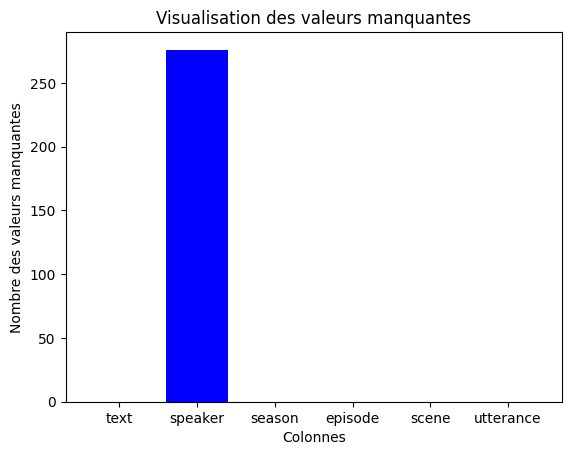

In [10]:
#Calculation du pourcentage des valeurs manquantes
missing_values = df.isnull().sum()
plt.bar(missing_values.index,missing_values.values, color='Blue')
plt.xlabel("Colonnes")
plt.ylabel("Nombre des valeurs manquantes")
plt.title("Visualisation des valeurs manquantes")
plt.show()

### 1.2 Analyse de fond

### 1.2.1 Analyse univarie

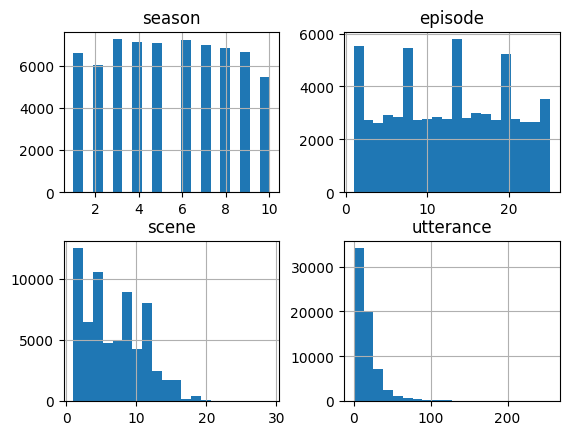

In [11]:
#Visualisation des variables
#Pour les donnees numeriques
numeric_cols = ["season","episode","scene","utterance"]
df[numeric_cols].hist(bins=20)
plt.show()


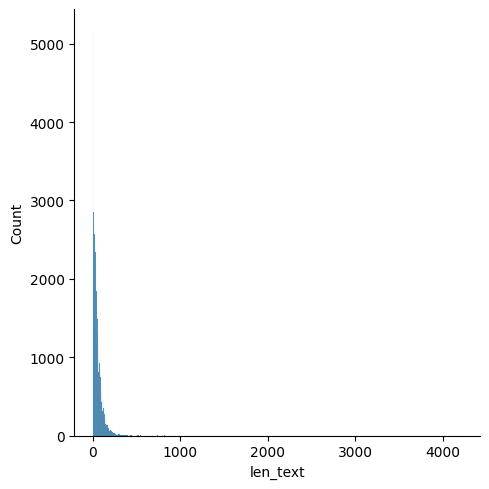

In [12]:
#Pour la colonne text
df['len_text'] = df['text'].str.len()
sns.displot(df['len_text'])
plt.show()


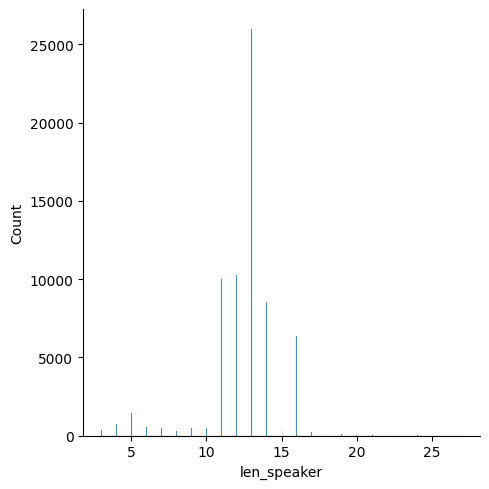

In [13]:
#Pour la colonne speaker
df['len_speaker'] = df['speaker'].str.len()
sns.displot(df['len_speaker'])
plt.show()


### 1.2.2 Analyse bivarie

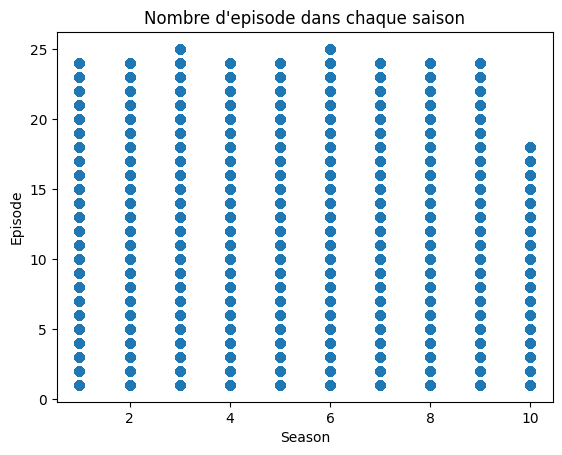

In [14]:
#Pour les deux colonnes season et episode
plt.scatter(df['season'], df['episode'])
plt.xlabel('Season')
plt.ylabel('Episode')
plt.title("Nombre d'episode dans chaque saison")
plt.show()

In [17]:
#Nombre de speakers dans chaque season
bar(data_frame=df[['season','speaker']].groupby(by=['season','speaker']).size().reset_index().rename({0:'count'}, axis=1), x='speaker',y='count',color='season')


In [19]:
#Top 7 speakers dans chaque saison
speakers = df['speaker'].value_counts().to_frame().reset_index().head(6)['speaker'].values
top_speakers = df[df['speaker'].isin(speakers)]
bar(data_frame=top_speakers[['season','speaker']].groupby(by=['season','speaker']).size().reset_index().rename({0:'count'}, axis=1), x='speaker',y='count',color='season')


### 1.2.3 Analyse multivarie

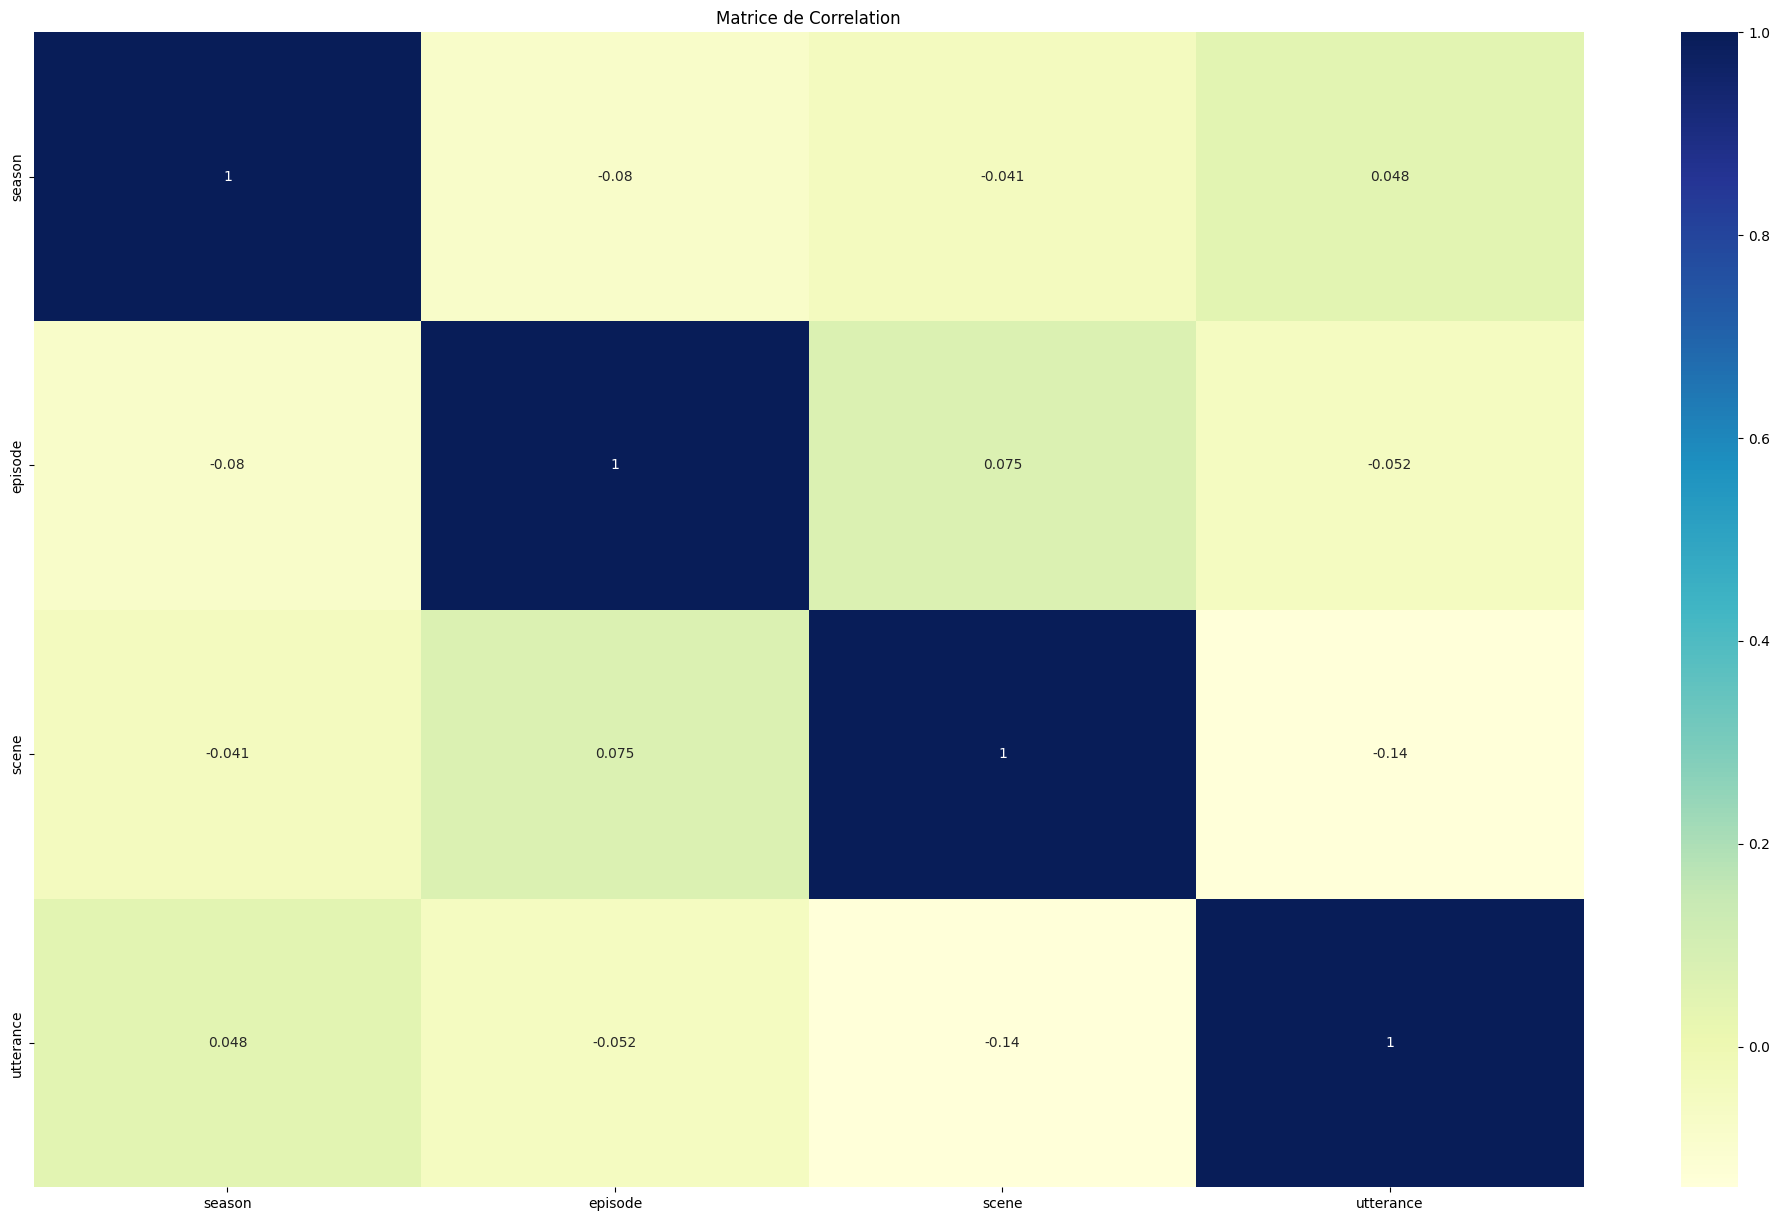

In [21]:
matrice = df[numeric_cols].corr()
plt.figure(figsize=(25, 15))
sns.heatmap(matrice, annot=True,cmap='YlGnBu')
plt.title('Matrice de Correlation')
plt.show()


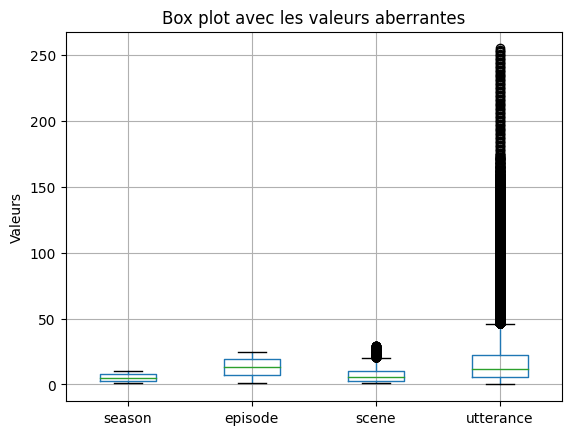

In [23]:
#Visualisation des valeurs aberrantes
df.boxplot(numeric_cols)
plt.ylabel("Valeurs")
plt.title("Box plot avec les valeurs aberrantes")
plt.show()

## 2. Pre-traitement

### 2.1 Nettoyage des donnees

### Missing values

In [25]:
df.isna().sum()

text             0
speaker        276
season           0
episode          0
scene            0
utterance        0
len_text         0
len_speaker    276
dtype: int64

### Filling in missing values

In [26]:
df.fillna(0, inplace=True)

### Fonction Pretraitement

In [104]:
def pretraitement(text):
    #Supprimer les indications sceniques et les annotations
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)

    #Supprimer les etiquettes des haut-parleurs
    text = re.sub(r'\b[A-Z][a-z]+\b:', '', text)
    return text


In [105]:
df['processed_text'] = df['text'].apply(pretraitement)

In [106]:
df.head(20)
#df.drop(columns=['processed_text'],inplace=True)


,text,speaker,season,episode,scene,utterance,len_text,len_speaker,processed_text
0,There's nothing to tell! He's just some guy I ...,Monica Geller,1,1,1,1,56,13.0,There's nothing to tell! He's just some guy I ...
1,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,1,1,1,2,80,14.0,"C'mon, you're going out with the guy! There's ..."
2,"All right Joey, be nice. So does he have a hum...",Chandler Bing,1,1,1,3,72,13.0,"All right Joey, be nice. So does he have a hum..."
3,"Wait, does he eat chalk?",Phoebe Buffay,1,1,1,4,24,13.0,"Wait, does he eat chalk?"
4,"(They all stare, bemused.)",Scene Directions,1,1,1,5,26,16.0,
5,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,1,1,1,6,79,13.0,"Just, 'cause, I don't want her to go through w..."
6,"Okay, everybody relax. This is not even a date...",Monica Geller,1,1,1,7,109,13.0,"Okay, everybody relax. This is not even a date..."
7,Sounds like a date to me.,Chandler Bing,1,1,1,8,25,13.0,Sounds like a date to me.
8,[Time Lapse],Scene Directions,1,1,1,9,12,16.0,
9,"Alright, so I'm back in high school, I'm stand...",Chandler Bing,1,1,1,10,115,13.0,"Alright, so I'm back in high school, I'm stand..."


### WordCloud de la colonne *text*

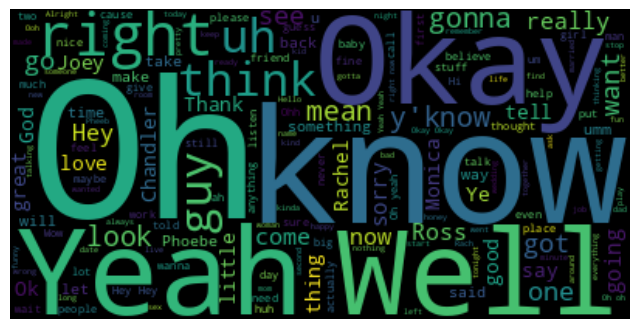

In [108]:
text_cloud = ''.join(df['processed_text'])
word_cloud = WordCloud()
word_cloud.generate(text_cloud)
plt.figure(figsize=(8, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [114]:
df.processed_text[df.speaker=='Joey Tribbiani']


1        C'mon, you're going out with the guy! There's ...
12                                          Instead of...?
14                                   Never had that dream.
21               This guy says hello, I wanna kill myself.
26                                                    Ohh.
                               ...                        
67322                                          I love you!
67323                                                 Hey!
67325                     So did you guys make it in time?
67356                           Has it always been purple?
67366                                    Yeah. I guess so.
Name: processed_text, Length: 8171, dtype: object

# Get Contextual data

In [ ]:
contexted = []#store rows of contextual data
n = 7#choose 7 previous responses as context to current response
text = df['text']
for i in range(n,len(df['text'])):
  row = []#store current response and its 7 previous responses
  prev = i - 1 - n #calculate starting index of context
  for j in range(i, prev, -1):
      row.append(df['text'][j])
  contexted.append(row)
contexted[:5]

[['Sounds like a date to me.',
  "Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.",
  "Just, 'cause, I don't want her to go through what I went through with Carl- oh!",
  '(They all stare, bemused.)',
  'Wait, does he eat chalk?',
  'All right Joey, be nice. So does he have a hump? A hump and a hairpiece?',
  "C'mon, you're going out with the guy! There's gotta be something wrong with him!",
  "There's nothing to tell! He's just some guy I work with!"],
 ['[Time Lapse]',
  'Sounds like a date to me.',
  "Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.",
  "Just, 'cause, I don't want her to go through what I went through with Carl- oh!",
  '(They all stare, bemused.)',
  'Wait, does he eat chalk?',
  'All right Joey, be nice. So does he have a hump? A hump and a hairpiece?',
  "C'mon, you're going out with the guy! There's gotta be something wrong with him!"],
 ["A

In [ ]:
columns = ['response','context'] + ['context '+str(i) for i in range(n-1)]#fisrt rwo is response second is context and also others are context
columns

['response',
 'context',
 'context 0',
 'context 1',
 'context 2',
 'context 3',
 'context 4',
 'context 5']

In [ ]:
data =pd.DataFrame.from_records(contexted, columns=columns)
data.head()

,response,context,context 0,context 1,context 2,context 3,context 4,context 5
0,Sounds like a date to me.,"Okay, everybody relax. This is not even a date...","Just, 'cause, I don't want her to go through w...","(They all stare, bemused.)","Wait, does he eat chalk?","All right Joey, be nice. So does he have a hum...","C'mon, you're going out with the guy! There's ...",There's nothing to tell! He's just some guy I ...
1,[Time Lapse],Sounds like a date to me.,"Okay, everybody relax. This is not even a date...","Just, 'cause, I don't want her to go through w...","(They all stare, bemused.)","Wait, does he eat chalk?","All right Joey, be nice. So does he have a hum...","C'mon, you're going out with the guy! There's ..."
2,"Alright, so I'm back in high school, I'm stand...",[Time Lapse],Sounds like a date to me.,"Okay, everybody relax. This is not even a date...","Just, 'cause, I don't want her to go through w...","(They all stare, bemused.)","Wait, does he eat chalk?","All right Joey, be nice. So does he have a hum..."
3,"Oh, yeah. Had that dream.","Alright, so I'm back in high school, I'm stand...",[Time Lapse],Sounds like a date to me.,"Okay, everybody relax. This is not even a date...","Just, 'cause, I don't want her to go through w...","(They all stare, bemused.)","Wait, does he eat chalk?"
4,"Then I look down, and I realize there's a phon...","Oh, yeah. Had that dream.","Alright, so I'm back in high school, I'm stand...",[Time Lapse],Sounds like a date to me.,"Okay, everybody relax. This is not even a date...","Just, 'cause, I don't want her to go through w...","(They all stare, bemused.)"


In [ ]:
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens,
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)

    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:hi
DialoGPT: Hi
>> User:what do you know about friends sitcom?
DialoGPT: I know about friends sitcom, but not about this.
>> User:what is your favorite character
DialoGPT: I know about this, but I don't know about this.
>> User:okay bye
DialoGPT: I know about this, but I don't know about this.
>> User:okay
DialoGPT: I know about this, but I don't know about this.


In [ ]:
!pip install transformers


In [ ]:
!pip install torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

# Load Model

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer #transformers is a Hugging face's library
import torch

In [ ]:
#Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
#Loading model
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1712: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
tokenizer

GPT2TokenizerFast(name_or_path='microsoft/DialoGPT-small', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

# Train/test

In [ ]:
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(data, test_size=0.2)
print("Length of trainig set:", len(train_set))
print("Length of validation set:",len(validation_set))

Length of trainig set: 53892
Length of validation set: 13474


In [ ]:
#reduire train and validation set
train_set = train_set.sample(15000)
validation_set = validation_set.sample(1500)

In [ ]:
import logging
import os
import pickle #save and load preproessed data
from transformers import PreTrainedTokenizer, MODEL_WITH_LM_HEAD_MAPPING, WEIGHTS_NAME,AutoConfig
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from pathlib import Path
from typing import Dict, List, Tuple

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

logger = logging.getLogger(__name__)#logging used for tracking what is happening in training and evaluation process
#Convert rows of dataframe into tokens and embedding it
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]#long array of tokens
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

#Convert dataframe into Pytorch dataset
class ConversationDataset(Dataset):
    def __init__(self, tokenizer, args, df, block_size=512):

        block_size = min(block_size, tokenizer.model_max_length)
        #block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)


# checkpoints

In [ ]:
# Cacheing and storing of data/checkpoints
import glob
import shutil
import numpy as np
import random
import re
def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [ ]:
from transformers import PreTrainedModel, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm, trange
try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [ ]:
# Main runner

def main(df_trn, df_val):
    args = Args()

    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)

    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [ ]:
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'FriendsGPT-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [ ]:
main(train_set, validation_set)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1712: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1060 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3750 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Iteration:   0%|          | 0/3750 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Iteration:   0%|          | 0/3750 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1712: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Evaluating:   0%|          | 0/375 [00:00<?, ?it/s]

{'perplexity_': tensor(6.9117)}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
model = AutoModelWithLMHead.from_pretrained('FriendsGPT-small')

# Let's chat for 5 lines
for step in range(20):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens,
    chat_history_ids = model.generate(bot_input_ids, max_length=10000,pad_token_id=tokenizer.eos_token_id)

    # pretty print last ouput tokens from bot
    print("Friends: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:hi joey
Friends: Hey.
>> User:who is monica
Friends: I'm Monica.
>> User:do you love chandler
Friends: no.
>> User:why, isn't chandler you husband?


KeyboardInterrupt: 

In [ ]:
!pip install python-telegram-bot==13.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.1/490.1 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.3.3
    Uninstalling cachetools-5.3.3:
      Successfully uninstalled cachetools-5.3.3
  Attempting uninstall: python-telegram-bot
    Found existing installation: python-telegram-bot 13.4
    Uninstalling python-telegram-bot-13.4:
      Successfully uninstalled python-telegram-bot-13.4


In [ ]:
!pip install transformers

In [ ]:
from telegram import Update, ForceReply
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the fine-tuned model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/chatbot_friends/FriendsGPT-small')
model = AutoModelForCausalLM.from_pretrained('/content/drive/MyDrive/chatbot_friends/FriendsGPT-small')

# Define the start command handler
def start(update: Update, _: CallbackContext) -> None:
    user = update.effective_user
    update.message.reply_markdown_v2(
        fr'Hi {user.mention_markdown_v2()}\! I am your chatbot.',
        reply_markup=ForceReply(selective=True),
    )

# Define the chat handler
def chat(update: Update, _: CallbackContext) -> None:
    user_input = update.message.text
    new_user_input_ids = tokenizer.encode(user_input + tokenizer.eos_token, return_tensors='pt')
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if 'chat_history_ids' in globals() else new_user_input_ids
    chat_history_ids = model.generate(bot_input_ids, max_length=1024, pad_token_id=tokenizer.eos_token_id)
    bot_response = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    update.message.reply_text(bot_response)

def main() -> None:
    # Initialize the bot
    updater = Updater("7097593647:AAG5d23Qatw9YUaLMQSzp6wicVmzhSgwMJQ")

    # Get the dispatcher to register handlers
    dispatcher = updater.dispatcher

    # Register the start command handler
    dispatcher.add_handler(CommandHandler("start", start))

    # Register the message handler
    dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, chat))

    # Start the bot
    updater.start_polling()
    updater.idle()

if __name__ == '__main__':
    main()
